# **Inversión de datos SEV teóricos**

Autores

- **Daniela Quintero**: [yejoandajudi200305@gmail.com](mailto:yejoandajudi200305@gmail.com)
- **Paul Goyes**: [goyes.yesid@gmail.com](mailto:goyes.yesid@gmail.com) 

Importar las librerías necesarias

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import plot_1d_layer_model

mpl.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 2

# Mediciones

In [2]:
# Mediciones sin desplazamiento estático

# Cargar el archivo
Datos_SEV = np.load("../FASE 1/SEV/DatosSEV.npy", allow_pickle=True).item()

# Extraer las variables
dobsSEV = Datos_SEV["dpredSEV"]
ab2  = Datos_SEV["ab2"]

In [3]:
dpred05 = 5*dobsSEV
dpred025 = 1/5*dobsSEV

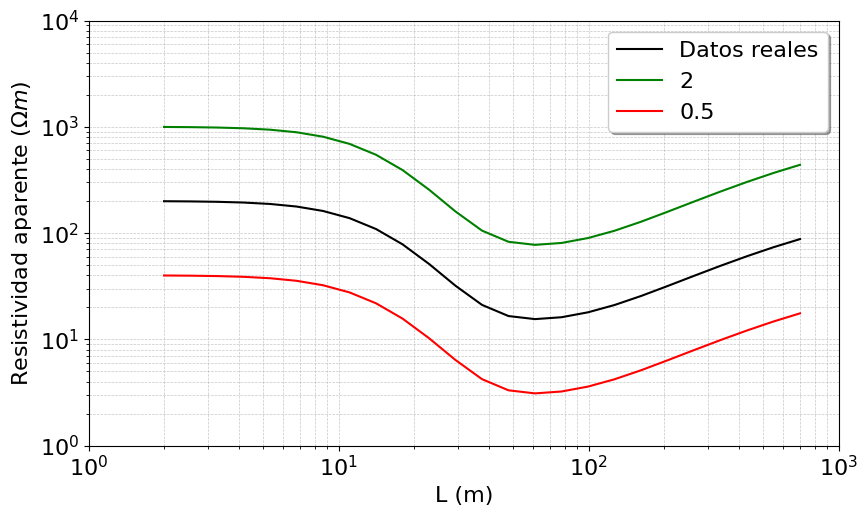

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax.loglog(ab2, dobsSEV, "black",  label='Datos reales')
ax.loglog(ab2, dpred05, "green", label='2')
ax.loglog(ab2, dpred025, "red", label='0.5')

ax.set_xlabel("L (m)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")
ax.set_ylim([10**0, 10**4])
ax.set_xlim([10**0, 10**3])
plt.legend(frameon=True, shadow=True)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## Arreglo

In [5]:
ab22= np.logspace(np.log10(2),np.log10(700),25)
ab22

array([  2.        ,   2.55289428,   3.25863461,   4.15947484,
         5.30934977,   6.77710433,   8.65061545,  11.04205337,
        14.09459746,  17.99100865,  22.96457156,  29.31306174,
        37.41657387,  47.76027877,  60.96347132,  77.81664872,
        99.32883884, 126.78801243, 161.83819607, 206.5779028 ,
       263.68577358, 336.580952  , 429.62779415, 548.39716985,
       700.        ])

In [6]:
# Arreglo tipo schlumberger

# Definir el espaciado de ab2 y número de sondeos
ab2= np.logspace(np.log10(2),np.log10(700),25) # Desde 1.5 metros a 200 metros

# Crear lista de las fuentes
source_list = []
for ii in range(0, len(ab2)):
    abb2 = ab2[ii]

    # Ubicación de los electrodos A y B
    A_location = np.r_[-abb2, 0.0, 0.0]
    B_location = np.r_[abb2, 0.0, 0.0]

    # Ubicación de los electrodos M y N
    M_location = np.r_[-abb2/3, 0.0, 0.0]
    N_location = np.r_[abb2/3, 0.0, 0.0]

    # Crear lista de receptores
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Definir las propiedades de las fuentes y receptores asociados
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Definir el arreglo
surveySEV = dc.Survey(source_list)

# **Inversión**

In [7]:
#Asignar incertidumbres y definir datos
uncertainties = 0.01 * np.abs(dobsSEV)
data_object = data.Data(surveySEV, dobs=dobsSEV, standard_deviation=uncertainties)

In [8]:
# Definir las celdas y extensión de la malla, debe ser 1.5 a 2 veces la DOI del método
layer_thicknesses =  np.logspace(0, 1.7, 15)

#1.7 y 15
# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

print(mesh)


  TensorMesh: 16 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     16          0.00        252.50      1.00     50.12    1.32




In [9]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(100 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

In [10]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=surveySEV,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [11]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh, alpha_s = 1e-8, alpha_x=1, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=20, maxIterCG=30)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [12]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [13]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        


C:\Users\DANIELA\anaconda3\envs\simpeg0230v3\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.72e+05  1.56e+06  0.00e+00  1.56e+06    1.18e+06      0              
   1  2.86e+05  2.32e+05  2.13e-07  2.32e+05    1.82e+05      0              
   2  1.43e+05  5.96e+04  3.57e-02  6.47e+04    2.37e+04      0   Skip BFGS  
   3  7.15e+04  2.49e+04  1.41e-01  3.50e+04    1.66e+04      0   Skip BFGS  
   4  3.58e+04  5.42e+03  2.66e-01  1.49e+04    7.89e+03      0              
   5  1.79e+04  2.28e+03  3.24e-01  8.08e+03    3.85e+03      0   Skip BFGS  
   6  8.94e+03  1.15e+03  3.69e-01  4.44e+03    2.32e+03      0   Skip BFGS  
   7  4.47e+03  5.86e+02  4.13e-01  2.43e+03    1.38e+03      0   Skip BFGS  
   8  2.24e+03  3.00e+02  4.59e-01  1.33e+03    8.21e+02      0   Skip BFGS  
   9  1.12e+03  1.60e+02

In [14]:
m2 = np.array([ 1010.87397275,   967.08954288,  1064.75010342,  1054.90693631,
         150.17823144,    97.12979431,    43.65932489,    66.24638975,
          77.76736939,    59.65404271,    53.08644625,   145.39634555,
         310.82047354, 15984.32674201,  3957.55155838,   663.02064089])

In [15]:
m3 = np.array([ 40.29535579,  38.96821293,  43.21962864,  37.10955431,
        10.59370027,   2.99588937,   1.25865505,   4.58261928,
         4.02520615,   0.8200226 ,   7.15675169,  27.27944228,
        56.7969056 , 128.23541194, 201.55425764,  44.36926535])

In [23]:
m2 = np.array([  990.08463937,   979.15099083,  1182.95830023,   787.29485064,
         276.76152105,    94.96561198,    51.49766469,    52.89376592,
          71.06090965,    71.24575062,    62.45107899,    95.12849964,
         450.86259622, 11121.50839114,    94.52183299, 30270.79794322])

In [26]:
m3 = np.array([ 39.74955617,  39.25738051,  47.4991109 ,  30.39044299,
        10.77859611,   4.36789972,   2.3540712 ,   1.7607054 ,
         2.42902996,   3.25119654,   3.21107047,   3.85030011,
         9.70884341,  38.66067685, 507.59245205,  48.76960477])

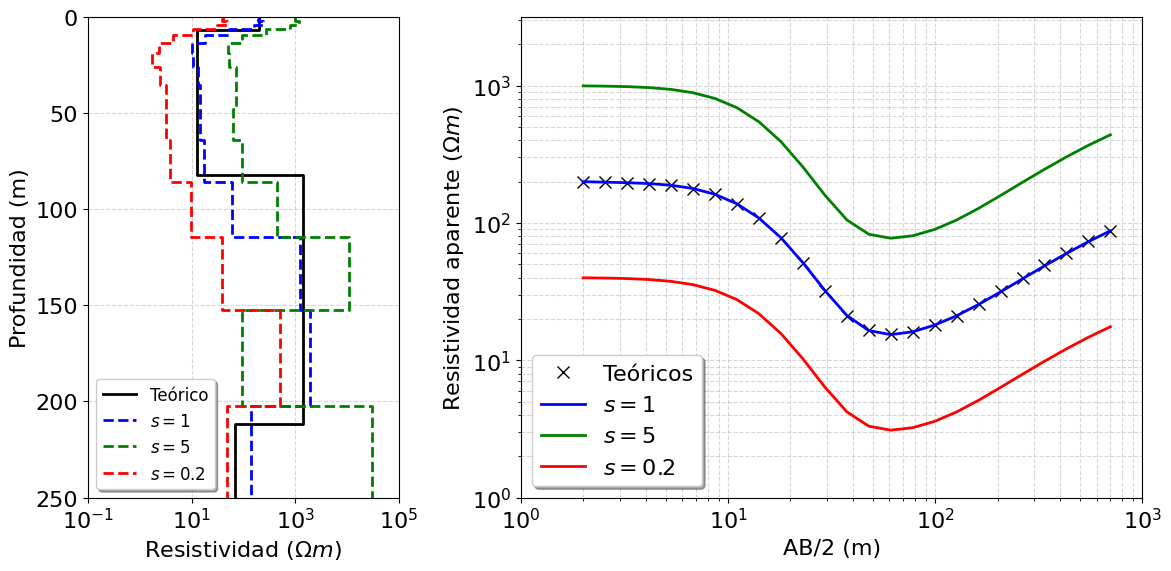

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# Definir espesores de las capas
true_layers = np.r_[7, 75, 130]

# Definir resistividades de las capas
true_model = np.r_[200, 13, 1400, 70]

# Crear la figura y los subgráficos
fig = plt.figure(figsize=(12, 6))  # Tamaño de la figura
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # 1 fila, 2 columnas (izquierda más estrecha)

# Subgráfico 1: Modelo de resistividades (izquierda)
ax1 = fig.add_subplot(gs[0])
plot_1d_layer_model(true_layers, true_model, ax=ax1, color="black", lw=2, label="Teórico")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    color="blue",
    linestyle='--',
    lw=2,
    label="$\mathit{s}=1$"
)
plot_1d_layer_model(layer_thicknesses,m2,ax=ax1,color="green",linestyle='--',lw=2,label="$\mathit{s}=5$")

plot_1d_layer_model(layer_thicknesses,m3,ax=ax1,color="red",linestyle='--',lw=2,label="$\mathit{s}=0.2$")

ax1.set_xlim([10**-1, 10**5])
ax1.set_ylim([250, 0])
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.legend(loc='lower left', frameon=True, shadow=True, fancybox=True, fontsize=12)

# Subgráfico 2: Mediciones de resistividad aparente (derecha)
ax2 = fig.add_subplot(gs[1])
ax2.loglog(ab2, dobsSEV, 'x', color="k", lw=2, label="Teóricos", markersize=8)  # Datos observados
ax2.loglog(ab2, inv_prob.dpred, color="blue", lw=2, label="$\mathit{s}=1$")  # Datos predichos
ax2.loglog(ab2, dpred05, color="green", lw=2, label="$\mathit{s}=5$")  # Datos predichos
ax2.loglog(ab2, dpred025, color="red", lw=2, label="$\mathit{s}=0.2$")  # Datos predichos

ax2.set_xlabel("AB/2 (m)")
ax2.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax2.set_ylim([10**0, 10**3.5])
ax2.set_xlim([10**0, 10**3])
ax2.grid(True, which="both", linestyle='--', alpha=0.5)
ax2.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Guardar la figura
filename = "Modelo_y_Mediciones_SEV4.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')

plt.show()

In [17]:
# Datos observados y predichos

# Calcular el MSE
mse = np.mean((dobsSEV - inv_prob.dpred) ** 2)

# Calcular el RMS
rms = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMS: {rms}")

MSE: 0.1085487971341548
RMS: 0.3294674447258102


In [18]:
model_map * recovered_model

array([ 203.62304774,  188.18175159,  238.69460419,  162.97440906,
         53.80938193,   17.87412508,   10.27437466,   10.87682315,
         13.59120896,   14.35103706,   14.34277865,   17.68848195,
         61.40959788, 1236.02404258, 1977.94018623,  139.29906475])